## Postprocessing - Reject Option Classification - Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import get_default_model_pipeline, reject_option_classification_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

## Build up the function using race

In [ ]:
# 1) Load COMPAS (race) data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run Experiment and Evaluat
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    X_train = train_df[feature_cols]
    y_train = train_df['label'].values
    X_test  = test_df[feature_cols]
    y_test  = test_df['label'].values

    pipeline = get_default_model_pipeline()
    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)

    train_probs = pipeline.predict_proba(X_train)[:, 1].reshape(-1, 1)
    test_probs  = pipeline.predict_proba(X_test)[:, 1].reshape(-1, 1)

    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    train_pred = train_bld.copy(deepcopy=True)
    train_pred.labels = y_train_pred.reshape(-1, 1)
    train_pred.scores = train_probs

    test_pred = test_bld.copy(deepcopy=True)
    test_pred.labels = y_test_pred.reshape(-1, 1)
    test_pred.scores = test_probs

    # Apply RejectOptionClassification with defaults
    roc = RejectOptionClassification(
        unprivileged_groups=[{protected: unprivileged_value}],
        privileged_groups=[{protected: privileged_value}]
        # all other parameters are left at their defaults
    )
    roc.fit(train_bld, train_pred)
    post_bld = roc.predict(test_pred)
    y_post = post_bld.labels.ravel()
    
    m = compute_metrics(
        test_df, y_test, y_post,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

In [ ]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_race_metrics_agg, 'Baseline', 'Sex', 'Default Prejudice Remover Compas: Baseline - Sex')

--------------------------------------------------------------------------------------------------------------------------------------

## default Reject Option Classification, sex

In [3]:
# 1) Load data
protected          = 'sex'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred_post = reject_option_classification_train_and_predict(
        df,
        train_idx,
        test_idx,
        feature_cols,
        protected,
        privileged_value,
        unprivileged_value
    )

    m = compute_metrics(
        test_df, y_test, y_pred_post,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_sex_metrics     = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean', 'std'])
print(compas_sex_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.665447  0.629781 -0.033008  0.929587 -0.017951  0.002272
std   0.010744  0.011849  0.035249  0.075388  0.056188  0.036340


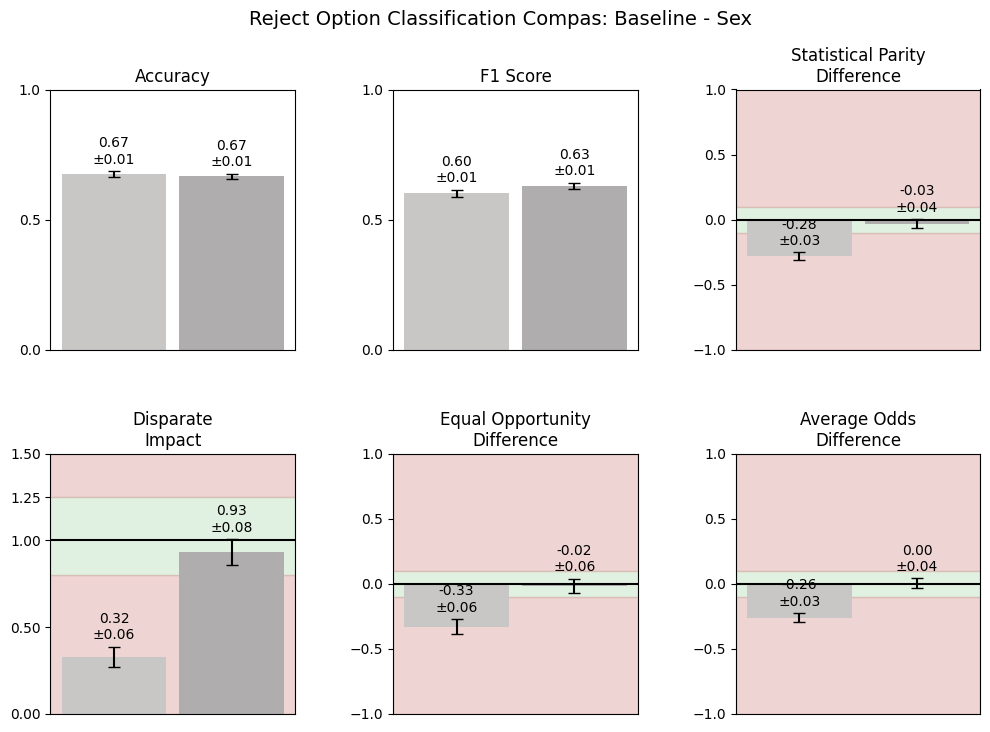

In [8]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Sex', 'Reject Option Classification Compas: Baseline - Sex')

## default  Reject Option Classification, race

In [5]:
# 1) Load data
protected          = 'race'
privileged_value   = 0.0
unprivileged_value = 1.0

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred_post = reject_option_classification_train_and_predict(
        df,
        train_idx,
        test_idx,
        feature_cols,
        protected,
        privileged_value,
        unprivileged_value
    )

    m = compute_metrics(
        test_df, y_test, y_pred_post,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
compas_race_metrics     = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean', 'std'])
print(compas_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.664172  0.640295 -0.045241  0.909325 -0.061873 -0.022301
std   0.013150  0.016951  0.039494  0.081416  0.040658  0.036524


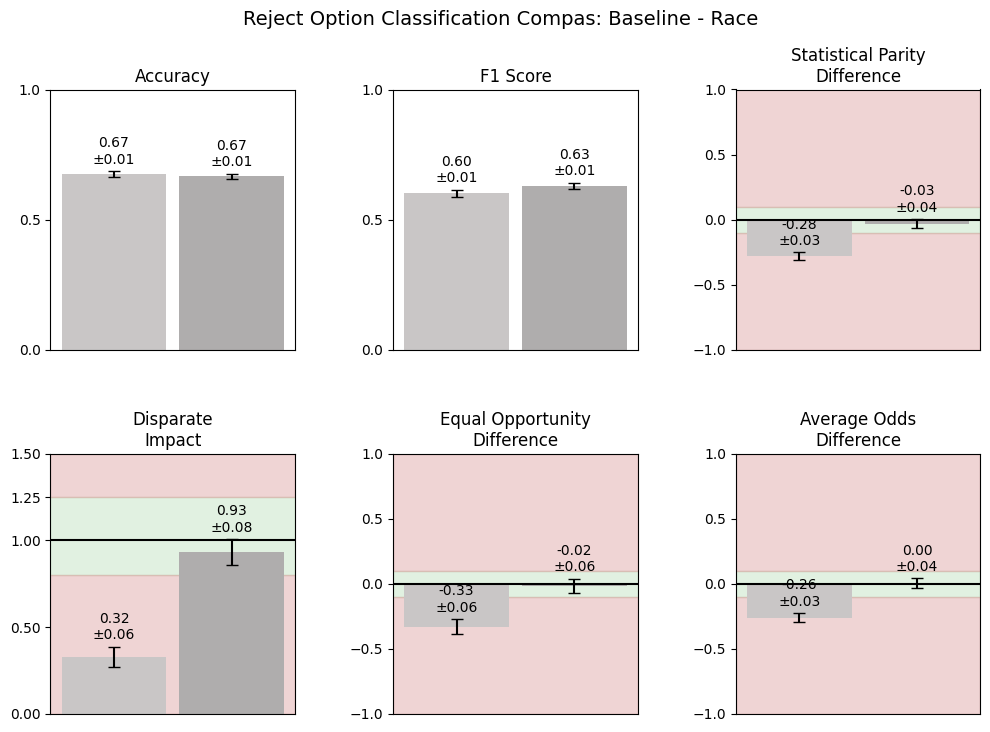

In [9]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Race', 'Reject Option Classification Compas: Baseline - Race')